In [3]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [9]:
BATCH_SIZE = 32 


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd8707b6c10>,
 ['pizza', 'steak', 'sushi'])

In [10]:
image_batch, label_batch = next(iter(train_dataloader))


image, label = image_batch[0], label_batch[0]


image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

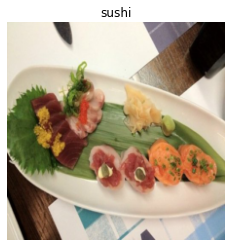

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [12]:
height = 224 
width = 224 
color_channels = 3 
patch_size = 16 

# (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"height (H={height}), (W={width}) patch size (P={patch_size}): {number_of_patches}")

height (H=224), (W=224) patch size (P=16): 196


In [13]:
embedding_layer_input_shape = (height, width, color_channels)


embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape : {embedding_layer_output_shape}")

Input shape : (224, 224, 3)
Output shape : (196, 768)


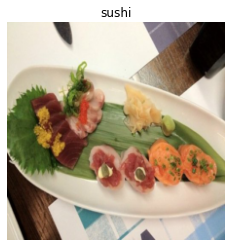

In [14]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

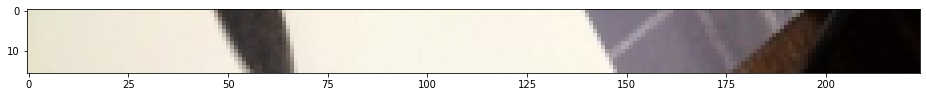

In [15]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


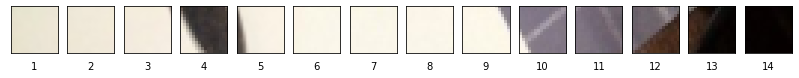

In [16]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "size must not be divisible by 0 size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) 
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


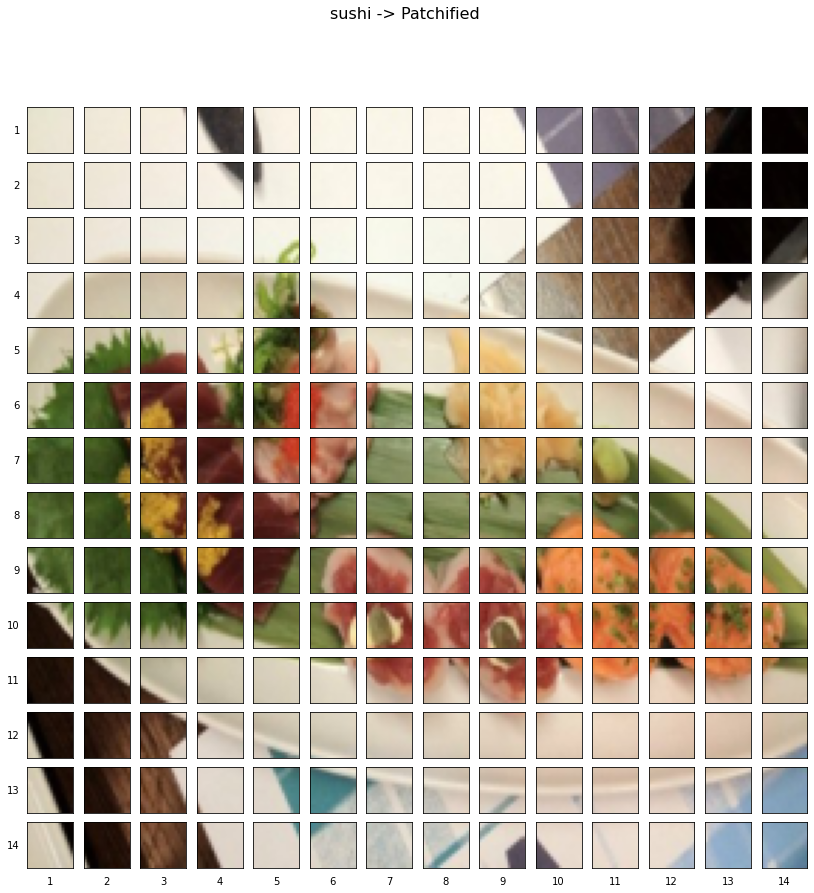

In [17]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")


fig, axs = plt.subplots(nrows=img_size // patch_size, 
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)


for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, 
                                        patch_width:patch_width+patch_size, 
                                        :]) 
        

        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [18]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

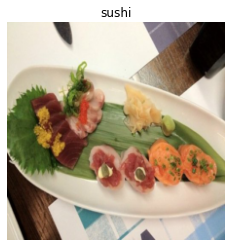

In [19]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

In [20]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


[438, 64, 98, 684, 451]


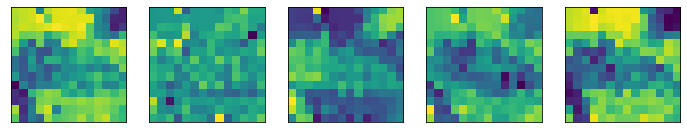

In [21]:
import random
random_indexes = random.sample(range(0, 758), k=5) 
print(random_indexes)


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [22]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.6616, 0.6779, 0.6625, 0.1311, 0.6911, 0.6968, 0.7013, 0.7005,
           0.7069, 0.2730, 0.3278, 0.1963, 0.1418, 0.0441],
          [0.6582, 0.6748, 0.6836, 0.6962, 0.4779, 0.6996, 0.6913, 0.6929,
           0.6930, 0.4432, 0.3436, 0.2116, 0.0552, 0.0426],
          [0.6604, 0.6339, 0.6617, 0.6728, 0.5897, 0.7349, 0.6871, 0.6823,
           0.5878, 0.6146, 0.3798, 0.2408, 0.0334, 0.1511],
          [0.5863, 0.5948, 0.5949, 0.6034, 0.4432, 0.7593, 0.6444, 0.6976,
           0.5936, 0.4843, 0.3960, 0.2939, 0.3539, 0.2567],
          [0.4870, 0.4712, 0.4547, 0.5048, 0.3996, 0.4201, 0.7072, 0.6155,
           0.7281, 0.6408, 0.5637, 0.4768, 0.6432, 0.5429],
          [0.4073, 0.2479, 0.1683, 0.2900, 0.3065, 0.5933, 0.4235, 0.5013,
           0.7364, 0.7147, 0.6259, 0.6033, 0.6891, 0.5335],
          [0.2187, 0.2341, 0.3058, 0.2124, 0.4956, 0.4577, 0.3901, 0.4424,
           0.5868, 0.5274, 0.4979, 0.7034, 0.6216, 0.6149],
          [0.2437, 0.1718, 0.4668, 0.3225, 0.3397, 0.27

In [23]:
print(f"Current tensor shape: {image_out_of_conv.shape}")

Current tensor shape: torch.Size([1, 768, 14, 14])


In [24]:
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


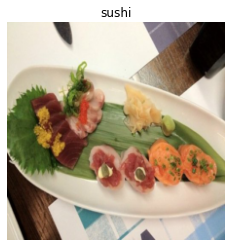

In [25]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);
print(f"{image.shape}")


image_out_of_conv = conv2d(image.unsqueeze(0)) 
print(f"{image_out_of_conv.shape}")


image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"{image_out_of_conv_flattened.shape}")

In [26]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) 
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


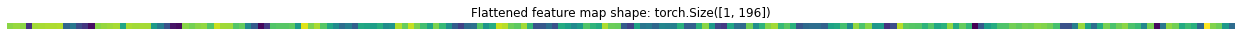

In [27]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] 


plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [28]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.6616, 0.6779, 0.6625, 0.1311, 0.6911, 0.6968, 0.7013, 0.7005, 0.7069,
          0.2730, 0.3278, 0.1963, 0.1418, 0.0441, 0.6582, 0.6748, 0.6836, 0.6962,
          0.4779, 0.6996, 0.6913, 0.6929, 0.6930, 0.4432, 0.3436, 0.2116, 0.0552,
          0.0426, 0.6604, 0.6339, 0.6617, 0.6728, 0.5897, 0.7349, 0.6871, 0.6823,
          0.5878, 0.6146, 0.3798, 0.2408, 0.0334, 0.1511, 0.5863, 0.5948, 0.5949,
          0.6034, 0.4432, 0.7593, 0.6444, 0.6976, 0.5936, 0.4843, 0.3960, 0.2939,
          0.3539, 0.2567, 0.4870, 0.4712, 0.4547, 0.5048, 0.3996, 0.4201, 0.7072,
          0.6155, 0.7281, 0.6408, 0.5637, 0.4768, 0.6432, 0.5429, 0.4073, 0.2479,
          0.1683, 0.2900, 0.3065, 0.5933, 0.4235, 0.5013, 0.7364, 0.7147, 0.6259,
          0.6033, 0.6891, 0.5335, 0.2187, 0.2341, 0.3058, 0.2124, 0.4956, 0.4577,
          0.3901, 0.4424, 0.5868, 0.5274, 0.4979, 0.7034, 0.6216, 0.6149, 0.2437,
          0.1718, 0.4668, 0.3225, 0.3397, 0.2772, 0.3749, 0.3579, 0.3530, 0.5129,
          0.2595

In [29]:
class PatchEmbedding(nn.Module):

    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)


        self.flatten = nn.Flatten(start_dim=2, 
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        return x_flattened.permute(0, 2, 1)

In [30]:
set_seeds()


patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)


print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [31]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) 


summary(PatchEmbedding(), 
        input_size=random_input_image, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [32]:
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape}")

tensor([[[-0.9459,  0.2537, -0.2612,  ...,  0.6953, -0.4298,  0.3267],
         [-0.9641,  0.2559, -0.2579,  ...,  0.7148, -0.4381,  0.3346],
         [-0.9718,  0.2191, -0.2713,  ...,  0.7297, -0.4317,  0.3592],
         ...,
         [-0.8599,  0.2463, -0.2609,  ...,  0.6093, -0.3716,  0.3225],
         [-0.6282,  0.1890, -0.2632,  ...,  0.5191, -0.3302,  0.2584],
         [-0.5716,  0.1727, -0.2400,  ...,  0.4860, -0.2759,  0.2500]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768])


In [33]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]


class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad=True) 


print(class_token[:, :, :10])


print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [34]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) 

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9459,  0.2537, -0.2612,  ...,  0.6953, -0.4298,  0.3267],
         [-0.9641,  0.2559, -0.2579,  ...,  0.7148, -0.4381,  0.3346],
         ...,
         [-0.8599,  0.2463, -0.2609,  ...,  0.6093, -0.3716,  0.3225],
         [-0.6282,  0.1890, -0.2632,  ...,  0.5191, -0.3302,  0.2584],
         [-0.5716,  0.1727, -0.2400,  ...,  0.4860, -0.2759,  0.2500]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9459,  0.2537, -0.2612,  ...,  0.6953, -0.4298,  0.3267],
          [-0.9641,  0.2559, -0.2579,  ...,  0.7148, -0.4381,  0.3346],
          ...,
          [-0.8599,  0.2463, -0.2609,  ...,  0.6093, -0.3716,  0.3225],
          [-0.6282,  0.1890, -0.2632,  ...,  0.5191, -0.3302,  0.2584],
          [-0.5716,  0.1727, -0.2400,  ...,  0.4860, -0.2759,  0.2500]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [36]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) 


print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0541, 1.2537, 0.7388,  ..., 1.6953, 0.5702, 1.3267],
         [0.0359, 1.2559, 0.7421,  ..., 1.7148, 0.5619, 1.3346],
         ...,
         [0.1401, 1.2463, 0.7391,  ..., 1.6093, 0.6284, 1.3225],
         [0.3718, 1.1890, 0.7368,  ..., 1.5191, 0.6698, 1.2584],
         [0.4284, 1.1727, 0.7600,  ..., 1.4860, 0.7241, 1.2500]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [38]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)


patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")


batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}")


patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) 


patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [39]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()
        

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x, 
                                             value=x, 
                                             need_weights=False)
        return attn_output

In [40]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072, 
                 dropout:float=0.1): 
        super().__init__()
        

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
    
   
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [41]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12,
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()


        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        

    def forward(self, x):
        
        x =  self.msa_block(x) + x 
        
        x = self.mlp_block(x) + x 
        
        return x

In [42]:
transformer_encoder_block = TransformerEncoderBlock()

In [43]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [50]:
# the almost same arch with built-in

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, 
                                                             nhead=12, 
                                                             dim_feedforward=3072, 
                                                             dropout=0.1, 
                                                             activation="gelu", 
                                                             batch_first=True,
                                                             norm_first=True) 

torch_transformer_encoder_layer

summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
print(torch_transformer_encoder_layer)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [51]:
# vision transformer
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 
        

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        

        self.num_patches = (img_size * img_size) // patch_size**2
                 

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    

    def forward(self, x):
        

        batch_size = x.shape[0]
        

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x  

In [52]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)


print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [53]:
set_seeds()


random_image_tensor = torch.randn(1, 3, 224, 224) 

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [54]:
summary(model=vit, 
        input_size=(32, 3, 224, 224), 
        # col_names=["input_size"], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [55]:
from going_modular.going_modular import engine

 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3)


loss_fn = torch.nn.CrossEntropyLoss()


set_seeds()


results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1948 | train_acc: 0.3633 | test_loss: 5.1218 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9518 | train_acc: 0.3320 | test_loss: 1.6203 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7584 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2244 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


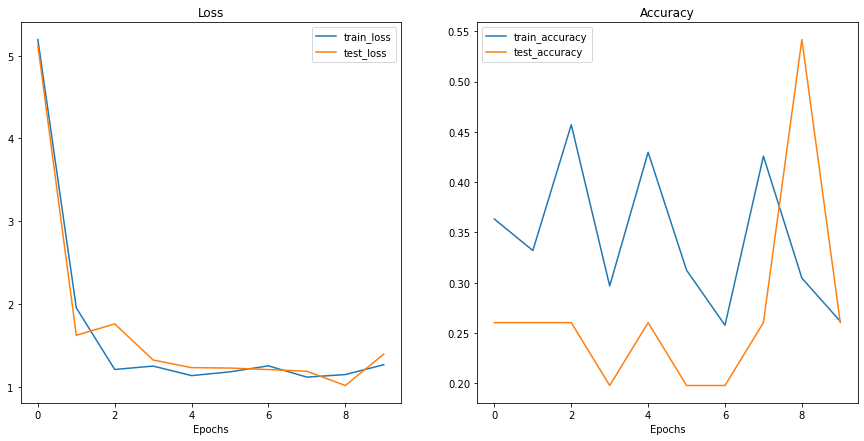

In [56]:
from helper_functions import plot_loss_curves


plot_loss_curves(results)

In [58]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 


pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [59]:
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [60]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [61]:
train_dir = image_path / "train"
test_dir = image_path / "test" 
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [62]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [63]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [64]:
from going_modular.going_modular import engine


optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


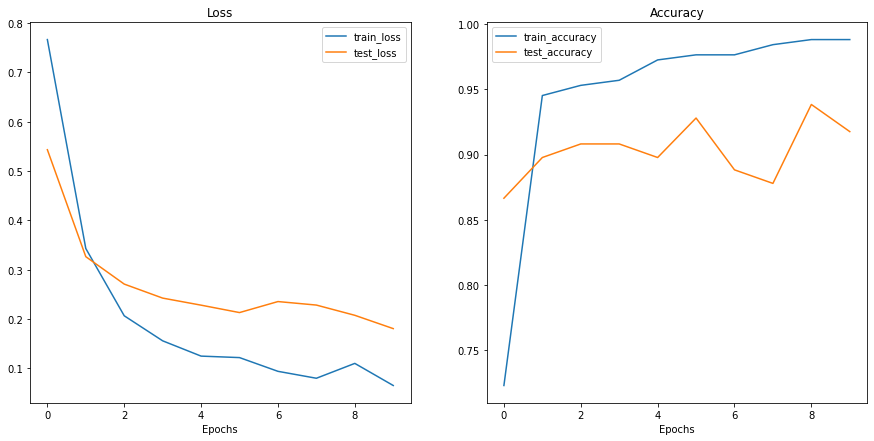

In [65]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

In [66]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [68]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


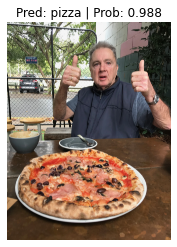

In [69]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)